In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
import os
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mapie.multi_label_classification import MapieMultiLabelClassifier
from scipy import integrate
from scipy.optimize import minimize
from sklearn.model_selection import KFold
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate import J, J_prime

%load_ext autoreload
%autoreload 2


In [3]:
DATASET = "polyp"
BASE_DIR = f"/home/vblot/multiaccurate_cp/data/{DATASET}"


In [4]:
IMG_SIZE = 64


In [5]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")


In [6]:
def load_data(pred_probas_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, label_file) in enumerate(tqdm(zip(sorted(os.listdir(pred_probas_dir)),
                                                                       sorted(os.listdir(labels_dir))))):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, labels


In [9]:
cal_pred_probas, cal_labels = load_data(DIR_CAL_PRED_PROBAS, DIR_CAL_LABELS)


0it [00:00, ?it/s]

252it [00:00, 730.77it/s] 


In [10]:
test_pred_probas, test_labels = load_data(DIR_TEST_PRED_PROBAS, DIR_TEST_LABELS)

546it [00:00, 863.03it/s] 


In [11]:
ALPHA = .1

In [12]:
class MapieWrapper():
    def __init__(self):
        self.trained_ = True
        self.classes_ = 1

    def fit(self, X, y=None):
        pass

    def predict_proba(self, X):
        return X

    def predict(self, X):
        pred_proba = self.predict_proba(X)
        return pred_proba >= .5

    def __sklearn_is_fitted__(self):
        return True

In [22]:
recalls = []
precisions = []

# kf = KFold(n_splits=100, shuffle=True, random_state=42)
    

n = len(cal_pred_probas)
mapie_crc = MapieMultiLabelClassifier(MapieWrapper(), method="crc")
for i in range(len(cal_labels)):
    X, y = cal_pred_probas[i], cal_labels[i]
    mapie_crc.partial_fit(X.ravel()[np.newaxis, :], y.ravel()[np.newaxis, :])

_, _ = mapie_crc.predict(test_pred_probas.ravel()[np.newaxis, :], alpha=ALPHA)
th_crc = mapie_crc.lambdas_star

y_pred_test_th = (test_pred_probas >= th_crc).astype(int)
recalls = (y_pred_test_th * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))
precisions = np.nan_to_num((y_pred_test_th * test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)




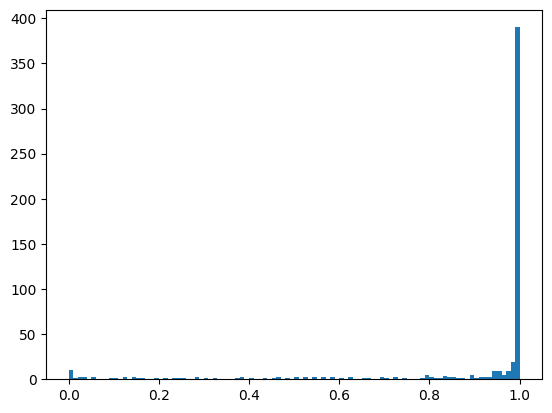

In [24]:
plt.hist(recalls, bins=100)
plt.show()

In [26]:
np.mean(recalls)

0.9038809354669456

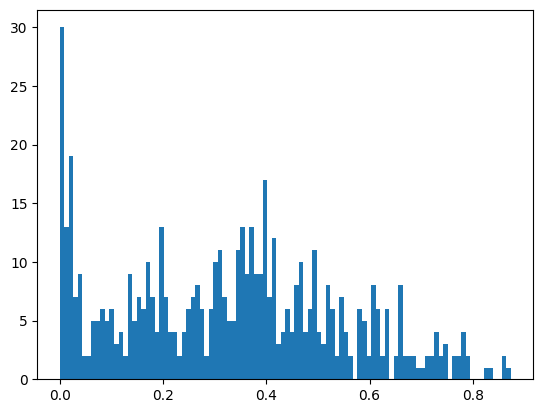

In [32]:
plt.hist(precisions, bins=100)
plt.show()

In [28]:
np.mean(precisions)

0.32784638242935255

In [31]:
np.median(precisions)

0.3398682651277228